In [1]:
## Read a single image from train dir
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
%matplotlib inline
from sklearn.externals import joblib

path='./train/'
def create_image_paths(filepath):
    image_paths = []
    for image_name in os.listdir(filepath):
        if image_name == '.DS_Store' or image_name == '.ipynb_checkpoints': continue
        elif image_name == 'codes.txt' : continue
        image_paths.append(filepath+image_name)
    image_paths.sort()
    return image_paths

image_paths = create_image_paths(path)
print(image_paths[:5])

['./train/AAA.png', './train/AAE.png', './train/AAGL.png', './train/AAQI.png', './train/AAR.png']


/Users/apple/anaconda3/envs/conda_env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


(150, 600, 3)


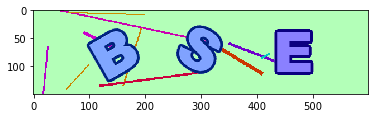

In [2]:
# Read a single image and plot
random_indices = np.random.permutation((len(image_paths)))
random_image = cv2.imread(image_paths[random_indices[0]])
print(random_image.shape)
imgplot = plt.imshow(random_image, cmap='gray')
plt.show()

[179 255 184]


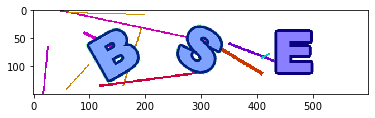

In [3]:
## Identify Background pixels
def find_mode_color(colors):
    flag=0
    for i in range(len(colors)):
        for j in range(i+1, len(colors)):
            if np.all(colors[i]==colors[j]) : return colors[i]
    return [255, 255, 255]

# Find the background color by taking average of 4 corners of the image
def mode_back_color(image):
    m=image.shape[0]
    n=image.shape[1]
    # Find corner colors
    colors = np.array([image[0, 0, :], image[m-1, 0, :], image[0, n-1, :], image[m-1, n-1, :]])
    return find_mode_color(colors)

# Find the background color for the random image
back_color = mode_back_color(random_image)
print(back_color)

# Remove the background color from the image
def remove_back_color(image, back_color):
    fore_image = np.copy(image)
    # Replace back color with black
    fore_image[(fore_image == back_color).all(axis = -1)] = [255, 255, 255]
    return fore_image

# Remove the background color from the random image and plot
random_fore_image = remove_back_color(random_image, back_color)
imgplot = plt.imshow(random_fore_image, cmap='gray')
plt.show()

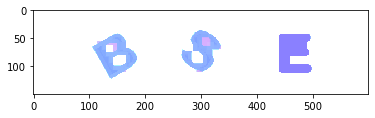

In [4]:
## Erode the obfuscating lines
def remove_back_lines(fore_image):
    dilate_image = np.copy(fore_image)
    # define the kernel with which you want to convolve for dilation
    kernel = np.ones((4, 4))
    dilate_image = cv2.dilate(fore_image, kernel, iterations=4)
    return dilate_image

random_dilate_image = remove_back_lines(random_fore_image)
imgplot = plt.imshow(random_dilate_image, cmap = 'gray')
plt.show()

(150, 600)


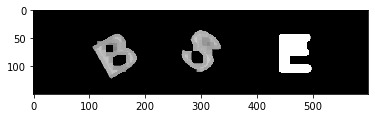

In [5]:
## Convert an image to grayscale
def convert_to_gray(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_image = cv2.bitwise_not(grayscale_image)
    return grayscale_image

random_gray_image = convert_to_gray(random_dilate_image)
print(random_gray_image.shape)
imgplot = plt.imshow(random_gray_image, cmap = 'gray')
plt.show()

In [6]:
## bfs visit at non black pixels
def bfs_visit(x, y, m, n, k, visit, image, threshold=1):
    visit[x][y]=k
    queue=[[x, y]]
    while(len(queue)>0):
        [i, j] = queue[0]
        queue.pop(0)
        # up
        if i>1 and image[i-1][j]>threshold and visit[i-1][j]==0 :
            queue.append([i-1, j])
            visit[i-1][j]=k
        # left
        if j>1 and image[i][j-1]>threshold and visit[i][j-1]==0 :
            queue.append([i, j-1])
            visit[i][j-1]=k      
        # down
        if i<m-1 and image[i+1][j]>threshold and visit[i+1][j]==0 :
            queue.append([i+1, j])
            visit[i+1][j]=k
        # right
        if j<n-1 and image[i][j+1]>threshold and visit[i][j+1]==0 :
            queue.append([i, j+1])
            visit[i][j+1]=k
    return visit

## find non_black and unvisited pixels and bfs_visit
def bfs(m, n, image, threshold):
    k=0
    visit = [[0 for j in range(n)] for i in range(m)]
    for x in range(m):
        for y in range(n):
            if image[x][y]<=threshold or visit[x][y]!=0 : continue
            k+=1
            visit=bfs_visit(x, y, m, n, k, visit, image, threshold)
    return k, visit

3
[[106  41 186 122]
 [265  35 335 109]
 [440  42 498 111]]


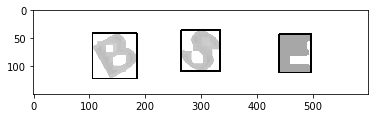

In [7]:
## Remove boxes where the max diff b/w xmin, xmax and ymin ymax is less than threshold
def valid_boxes(boxes, threshold):
    boxes_after_removal = []
    k=0
    for box in boxes:
        min_diff = min(box[2]-box[0], box[3]-box[1])
        if(min_diff<=threshold): continue
        k+=1
        boxes_after_removal.append(box)
    return k, np.array(boxes_after_removal)

## Find the bounding boxes of the connected regions in the image
def find_boxes(image, image_threshold=1, box_threshold=10):
    m=image.shape[0]
    n=image.shape[1]
    K, visit = bfs(m, n, image, image_threshold)
    limits = [[n, m, -n, -m] for k in range(K)]
    for i in range(m):
        for j in range(n):
            if image[i][j]<=image_threshold : continue
            k=visit[i][j]-1
            # left
            limits[k][0]=min(j, limits[k][0])
            # up
            limits[k][1]=min(i, limits[k][1])
            # right
            limits[k][2]=max(j, limits[k][2])
            # down
            limits[k][3]=max(i, limits[k][3])
    limits.sort()
    return valid_boxes(limits, box_threshold)

letters, random_boxes = find_boxes(random_gray_image, 1, 10)
print(letters)
print(random_boxes)

# Plot rectangles in the image
def plot_rectangles(image, boxes):
    image = cv2.bitwise_not(image)
    for box in boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 0), 2)
    imgplot = plt.imshow(image, cmap='gray')
    plt.show()
    return

plot_rectangles(random_gray_image, random_boxes)

In [8]:
## Create a dictionary to find the letters in image_paths
def create_dictionary(image_paths):
    dictionary={}
    for image_path in image_paths:
        if image_path[-8]=='/': 
            dictionary[image_path]=[image_path[-7], image_path[-6], image_path[-5]]
        else :
            dictionary[image_path]=[image_path[-8], image_path[-7], image_path[-6], image_path[-5]]
    return dictionary

dictionary = create_dictionary(image_paths)
print(len(dictionary))

## Train-Test split in a given ratio
def split_image_paths(image_paths, ratio=0.2):
    np.random.shuffle(image_paths)
    last_index=int(len(image_paths)*ratio)
    test_paths=image_paths[:last_index]
    train_paths=image_paths[last_index:]
    return train_paths, test_paths

train_paths, val_paths = split_image_paths(image_paths, 0.25)
print(len(train_paths), len(val_paths))

2000
1500 500


In [9]:
## Create X, Y for train and test dataset
def create_X_Y(image_paths, dictionary, image_threshold=1, box_threshold=10, 
               x_dimension=110, y_dimension=110):
    X=[]
    Y=[]
    x_max_diff=-np.float('inf')
    y_max_diff=-np.float('inf')
    for i in range(len(image_paths)):
        if(i%100==0): print("Iteration =", i)
        # read
        image = cv2.imread(image_paths[i])
        # background color
        back_color = mode_back_color(image)
        # remove background color
        fore_image = remove_back_color(image, back_color)
        # remove obfuscating lines
        dilate_image = remove_back_lines(fore_image)
        # fade to black
        gray_image = convert_to_gray(dilate_image)
        # Find connected componenets and boxes
        letters, boxes = find_boxes(gray_image, image_threshold, box_threshold)
        for j in range(len(boxes)):
            # crop the box out of the gray image, pad it with zeros and flatten
            crop_image = gray_image[boxes[j][1]:boxes[j][3], boxes[j][0]:boxes[j][2]]
            pad_image = np.zeros((x_dimension, y_dimension))
            pad_image[:crop_image.shape[0], :crop_image.shape[1]]=crop_image
            flatten_image = pad_image.flatten('F')
            # find the corresponding label
            label = ord(dictionary[image_paths[i]][j])-ord('A')
            X.append(flatten_image)
            Y.append(label)
    return np.array(X), np.array(Y)

In [10]:
# ## Create and Save X_train, Y_train, X_test, Y_test to csv files
# X_train, Y_train = create_X_Y(train_paths, dictionary, 1, 10, 110, 110)
# X_val, Y_val = create_X_Y(val_paths, dictionary, 1, 10, 110, 110)
# # Save
# X_train_df = pd.DataFrame(X_train)
# X_train_df.to_csv("./X_train.csv")

# X_val_df = pd.DataFrame(X_val)
# X_val_df.to_csv("./X_val.csv")

# Y_train_df = pd.DataFrame(Y_train)
# Y_train_df.to_csv("./Y_train.csv")

# Y_val_df = pd.DataFrame(Y_val)
# Y_val_df.to_csv("./Y_val.csv")
# print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

In [11]:
## Load X_train, X_test, Y_train, Y_test
X_train_df = pd.read_csv("./X_train.csv")
X_train_df.drop(X_train_df.columns[0], axis=1, inplace=True)
X_train = X_train_df.values

X_val_df = pd.read_csv("./X_val.csv")
X_val_df.drop(X_val_df.columns[0], axis=1, inplace=True)
X_val = X_val_df.values

Y_train_df = pd.read_csv("./Y_train.csv")
Y_train_df.drop(Y_train_df.columns[0], axis=1, inplace=True)
Y_train = Y_train_df.values
Y_train = Y_train[:, 0]

Y_val_df = pd.read_csv("./Y_val.csv")
Y_val_df.drop(Y_val_df.columns[0], axis=1, inplace=True)
Y_val = Y_val_df.values
Y_val = Y_val[:, 0]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(5271, 12100) (5271,) (1737, 12100) (1737,)


In [12]:
## Train the SVM multi-class classifier using X_train and Y_train and Save

# classifier = SVC(C=2.0, kernel='rbf', gamma='scale', max_iter=-1, decision_function_shape='ovr')
# classifier.fit(X_train, Y_train)
# joblib.dump(classifier, './gaussian_svm.pkl')

classifier = LinearSVC(penalty='l2', loss='squared_hinge', C=1.0, max_iter=10000,  multi_class='ovr')
classifier.fit(X_train, Y_train)
joblib.dump(classifier, './linear_svm.pkl')

## Load the SVM classifier
# classifier = joblib.load('./gaussian_svm.pkl')
# classifier = joblib.load('./linear_svm.pkl')

## Given a test image, predict the charcacters it contains
def predict_on_test_image(test_image, classifier, image_threshold=1, box_threshold=10,
                    x_dimension=110, y_dimension=110):
    string=""
    # find background color
    back_color = mode_back_color(test_image)
    # remove background color
    fore_image = remove_back_color(test_image, back_color)
    # remove obfuscating lines
    dilate_image = remove_back_lines(fore_image)
    # fade to black
    gray_image = convert_to_gray(dilate_image)
    # Find connected componenets and boxes
    letters, boxes = find_boxes(gray_image, image_threshold, box_threshold)
    for j in range(min(len(boxes), 4)):
        # crop the box out of the gray image, pad it with zeros and flatten
        crop_image = gray_image[boxes[j][1]:boxes[j][3], boxes[j][0]:boxes[j][2]]
        pad_image = np.zeros((x_dimension, y_dimension))
        pad_image[:crop_image.shape[0], :crop_image.shape[1]]=crop_image
        flatten_image = pad_image.flatten('F')
        # reshape flatten image for sending it into classifer
        flatten_image = np.reshape(flatten_image, [1]+list(flatten_image.shape))
        # predict the corresponding label
        integer_label = classifier.predict(flatten_image)
        char_label = chr(ord('A')+integer_label)
        string+=char_label
    return string

print(predict_on_test_image(random_image, classifier))

BSE


In [13]:
## Define evaluation metric, scoring function and result
def metric(predict_string, actual_string): 
    m = len(predict_string) 
    n = len(actual_string) 
    L = [[0 for j in range(n+1)] for i in range(m+1)] 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : L[i][j] = 0
            elif predict_string[i-1] == actual_string[j-1]: L[i][j] = L[i-1][j-1]+1
            else: L[i][j] = max(L[i-1][j], L[i][j-1]) 
    return L[m][n] 

def result(test_paths, dictionary, classifier):
    image_threshold=1
    box_threshold=10
    x_dimension=110
    y_dimension=110
    predict_list=[]
    actual_list=[]
    score=0
    for test_path in test_paths:
        test_image = cv2.imread(test_path)
        predict_string = predict_on_test_image(test_image, classifier, image_threshold, box_threshold,
                                               x_dimension, y_dimension)
        actual_string = "".join(dictionary[test_path])
        score+=metric(predict_string, actual_string)/len(actual_string)
    return score/len(test_paths)

print(result(val_paths, dictionary, classifier))

1.0


In [14]:
## Given a list of filepaths, retuclassifierlength of strings and the list of strings
def decaptcha(test_paths):
    image_threshold=1
    box_threshold=10
    x_dimension=110
    y_dimension=110
    strings = []
    length_of_strings=[]
    # Load the svm classifier
#     classifier = joblib.load('./gaussian_svm.pkl')
    classifier = joblib.load('./linear_svm.pkl')
    for test_path in test_paths:
        test_image = cv2.imread(test_path)
        string = predict_on_test_image(test_image, classifier, image_threshold, box_threshold,
                                       x_dimension, y_dimension)
        strings.append(string)
        length_of_strings.append(len(string))
    return np.array(length_of_strings), strings

## Test
test_path = "./test/"
test_paths = create_image_paths(test_path)
decaptcha(test_paths)

(array([3, 4]), ['BGZ', 'BHAE'])